## Import necessary python modules

In [1]:
import os
from pathlib import Path
import napari
import trackpy as tp
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
import bigfish
import bigfish.plot as plot
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
from tkinter import *
import tkinter as tk
from tkinter import filedialog
from random import sample 
pd.set_option('display.max_rows', 1500)
from copy import deepcopy
from dask.array.image import imread as imr
from bigfish.detection.utils import get_object_radius_pixel

from pathlib import Path
from napari.layers import Image
from magicgui import magicgui, magic_factory, widgets
from magicgui.widgets import Table
import bigfish.segmentation as segmentation
from skimage.segmentation import find_boundaries
from skimage.morphology.selem import disk
from napari.types import ImageData, LabelsData
from skimage.measure import label, regionprops

C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\bigfish\segmentation\nuc_segmentation.py:16: FutureWarning: The `skimage.morphology.selem` module is deprecated and will be removed in scikit-image 1.0 (`skimage.morphology.selem` has been moved to `skimage.morphology.footprints`).
  from skimage.morphology.selem import disk


## Specify voxel and object size


In [2]:
voxelRadius = (600, 121, 121)
objectRadius = (600, 150, 150)

In [3]:
from scipy.optimize import curve_fit

def bi_exp(x, a, b, c, d):
    return (a * np.exp(-b * x)) + (c * np.exp(-d * x))

def trip_exp(x, a, b, c, d, e, f):
    return ((a * np.exp(-b * x)) + (c * np.exp(-d * x)) + (e * np.exp(-f * x)))

def getBleachCorrected(stackCell, model='bi'):
    axes = tuple([i for i in range(len(stackCell.shape))])
    I_mean = np.mean(stackCell, axis=axes[1:])
    timePoints = np.arange(stackCell.shape[0])
    
    if model=='bi':
        coeffsExp, _ = curve_fit(bi_exp, timePoints, I_mean, maxfev=50000)
        f_ = np.vectorize(bi_exp)(timePoints, *coeffsExp)
    elif model=='tri':
        coeffsExp, _ = curve_fit(trip_exp, timePoints, I_mean, maxfev=50000)
        f_ = np.vectorize(trip_exp)(timePoints, *coeffsExp)
    
    
    f = f_ / np.max(f_)
    f = f.reshape(-1, 1, 1, 1)
    imagesCorrected = (stackCell / f).astype(np.uint16)

    # calculate r squared
    residuals = I_mean - f_
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((I_mean - np.mean(I_mean)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared_exp = np.array(r_squared)
    return imagesCorrected, r_squared_exp, I_mean

def getImagesAndSpotList(sequenceCell, selectedThreshold, voxelRadius, objectRadius, sampling=10):
    images=[]    
    spots_list=[]
    MaxTimePoint = sequenceCell.shape[0]

    spot_radius_px = detection.get_object_radius_pixel(
        voxel_size_nm=voxelRadius, 
        object_radius_nm=objectRadius, 
        ndim=3)

    for t in range(1,MaxTimePoint,sampling):
        rna = np.array(sequenceCell[t])
        images.append(rna)

        # LoG filter
        rna_log = stack.log_filter(rna, sigma=spot_radius_px)

        # local maximum detection
        mask = detection.local_maximum_detection(rna_log, min_distance=spot_radius_px)

        # thresholding
        threshold = detection.automated_threshold_setting(rna_log, mask)
        spots_, _ = detection.spots_thresholding(rna_log, mask, float(selectedThreshold))
        spots_list.append(spots_)
    n=len(images)
    print("Total number of images : "+str(n))
    return images, spots_list, n

def choose_home_folder():
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    file_path = filedialog.askdirectory(initialdir= "/", title='Please select a directory')  # Open file dialog

    root.destroy()  # Close the tkinter window
    return file_path


def findFitstTxFrame(blurClusters):
    for i in range(len(blurClusters)):  
        if blurClusters[i].size!=0:
            return i

def findSpotBrightness2D(spotList, blurImage):
    meanBrightness = []
    for hh in range(len(spotList)):
#         z = spotList[hh,0]
        y = spotList[hh,0]
        x = spotList[hh,1]
        meanBrightness.append(np.sum(np.array(blurImage[y-3:y+4,x-3:x+4])))
    return meanBrightness

from runBigfishDetection import getSpotAndClusters
def mergeTxSites(clusterFrames):
    newCluster = np.zeros((1,5))
    newCluster[0,0:3]=clusterFrames[np.argmax(clusterFrames[:,3]), 0:3]
    newCluster[0,3]= np.sum(clusterFrames[:,3])
    return newCluster


def df2List(potentialTxs):
    newClusterFrame=[]
    
    for i in range(len(potentialTxs)):
        if potentialTxs.iloc[i,1:].sum()!=0:
            newClusterFrame.append(np.array(potentialTxs.iloc[i,1:]).reshape((1, 5)))
        else:
            newClusterFrame.append(np.array([], dtype=np.int64).reshape((0, 5)))
    return newClusterFrame
def findSpotBrightness(spotList, sequenceCell):
    meanBrightness = []
    for hh in range(len(spotList)):
        z = spotList[hh,0]
        y = spotList[hh,1]
        x = spotList[hh,2]
        meanBrightness.append(np.sum(np.array(sequenceCell[z-3:z+4,y-3:y+4,x-3:x+4])))
    return meanBrightness

def findMissingTxSite(selectedThreshold, sequenceCell, reference_spot,cellNumber,Tx_label_clean, t, lastLocation, bETA, gAMA=5, numCs=2, rCls=600, vR=(600,121,121), oR=(400,202,202), reorderyn = False):
    spots_T, clusters_T, _ = getSpotAndClusters(sequenceCell,
                                             reference_spot, 
                                             cellnumber=cellNumber, 
                                             startTime=t,
                                             stopTime=t+1, 
                                             thresholdManual=selectedThreshold, 
                                             beta=bETA, 
                                             gamma=gAMA,
                                             numberOfSpots=numCs,
                                             radiusCluster=rCls, 
                                             voxelSize=vR, 
                                             objectSize=oR,
                                             reorder=reorderyn,
                                             extensionMov='.tif',
                                             showProgress=False)
#     print(spots_T, clusters_T)
#     print('last loc: ', lastLocation)
    if len(clusters_T[0])>3*len(spots_T[0]):
        print(len(spots_T[0]))
        print(len(clusters_T[0]))
        print('beta very low! Increase the beta!')
        
    mask_in_frames = Tx_label_clean[clusters_T[0][:,1], clusters_T[0][:,2]]
#     print(clusters_T)
    mask_in_frames = Tx_label_clean[clusters_T[0][:,1], clusters_T[0][:,2]]
    missingTx0 = clusters_T[0][mask_in_frames]

#     print(missingTx0)
    if missingTx0.size!=0:
        idxs = np.where(np.sum(np.abs(missingTx0[:,0:3] - lastLocation), axis=1)<=10)[0]
        if idxs.size!=0:
            missingTx = mergeTxSites(missingTx0[idxs,:])
            return missingTx
        else:
            print('not found (not close to last location)')
            return missingTx0[idxs,:]
    else:
        print('not found (not in mask)')
        return missingTx0

def df2ClusterData(potentialTxs):
    newClusterFrame=[]
    
    for i in range(MaxTimePoint):
        if np.sum(potentialTxs.loc[potentialTxs['frame']==i][['z','y', 'x','mrna']]).sum()!=0:
            clustersFound = np.array(potentialTxs.loc[potentialTxs['frame']==i][['z','y', 'x','mrna', 'cluster_id']])
            lsize=sum(np.sum(clustersFound[:,:-1], axis=1).astype(bool))
            newClusterFrame.append(clustersFound[np.sum(clustersFound[:,:-1], axis=1).astype(bool)].reshape((lsize, 5)))
        else:
            newClusterFrame.append(np.array([], dtype=np.int64).reshape((0, 5)))
    return newClusterFrame

def makeTrackData(potentialTxsFinal):
    newClusterFrame = df2ClusterData(potentialTxsFinal)
    columnsid=['frame']
    for clidu in np.unique(potentialTxsFinal.cluster_id):
        if clidu ==0:
            Tx1 = potentialTxsFinal[potentialTxsFinal['cluster_id']==0]
            tableToDisplay = pd.DataFrame(Tx1.loc[:,['frame', 'mrna']].astype(int))
            columnsid.append('mrna_'+str(clidu))
        else:
            Tx2 = potentialTxsFinal[potentialTxsFinal['cluster_id']==clidu]
            tableToDisplay = pd.concat([tableToDisplay , Tx2.loc[:,['mrna']].astype(int)], axis=1)
            columnsid.append('mrna_'+str(clidu))
    tableToDisplay.columns = columnsid
    columnHd = tableToDisplay.columns[1:]
    dftracksFinal = pd.concat([potentialTxsFinal['cluster_id'],potentialTxsFinal['frame'],potentialTxsFinal.loc[:,['y','x']]], axis=1)
    dd=dftracksFinal.sort_values(by=['cluster_id', 'frame'])
    tracks_data = np.asarray(dd)
    dftracksFinal = dftracksFinal[np.sum(dftracksFinal.iloc[:,2:],axis=1)!=0]
    return columnHd, newClusterFrame, tableToDisplay, dftracksFinal

In [4]:
def setProbability(part1Test):
    probTx = np.zeros((900,1))
    windowSize=5
    start=windowSize//2
    stop=MaxTimePoint-start

    for t in part1Test.frame.values:
        for ii in np.arange(-(windowSize-1)//2,(windowSize+1)//2,1):
            probTx[t+ii] = probTx[t+ii]+(1/9)
    return probTx

def findDetectedTxs(clsFrm, part1Test, MaxTimePoint, probTx):
    potentialTxs = pd.DataFrame(np.zeros([MaxTimePoint, 1+3+1]), columns=['frame', 'z', 'y', 'x', 'mrna'])
    potentialTxs['frame']= np.arange(0,MaxTimePoint,1)
    lastLocation = clsFrm[findFitstTxFrame(clsFrm)][:,1:3]
    for frameNumber in range(0,MaxTimePoint):
        clsFrmSrtd=clsFrm[frameNumber][np.argsort(clsFrm[frameNumber][:,0]),:]
        if len(clsFrm[frameNumber])>2:
    #         print('more than two found at', frameNumber)
            idx = np.where(np.sum(np.power(clsFrmSrtd[:,1:3]-np.array(lastLocation),2), axis=1)<=60)[0]
            if idx.size!=0:
                validIdxs=np.unique(idx)
                clsFrm[frameNumber] = mergeTxSites(clsFrmSrtd[validIdxs,:])
    #             print('merged')
            elif idx.size==0:
                t = part1Test.frame.values[np.argmin(abs(part1Test.frame.values-frameNumber))]
                if np.abs(t-frameNumber)<=5:        
                    particleCoordinates = np.asarray(part1Test[part1Test['frame']==t])[0][:2]
                    print('possible error, looking for hct at t', t)
                    idxnew = np.where(np.sum(np.power(clsFrmSrtd[:,1:3]-particleCoordinates,2), axis=1)<=70)[0]
                    if idxnew.size!=0:
                        clsFrm[frameNumber] = mergeTxSites(clsFrmSrtd[idxnew,:])
                        print('new tx found', frameNumber)
                        potentialTxs.loc[potentialTxs['frame']==frameNumber,['z', 'y', 'x', 'mrna']] = clsFrm[frameNumber][0][0:4]
                        lastLocation = np.array(potentialTxs.loc[potentialTxs['frame']==frameNumber,['y', 'x']])
                    if idxnew.size==0:
                        if probTx[frameNumber]>0.7:
                            idxnew2 = np.where(np.sum(np.abs(clsFrmSrtd[:,1:3]-particleCoordinates), axis=1)<=70)[0]
                            clsFrm[frameNumber] = mergeTxSites(clsFrmSrtd[idxnew2,:])
                            print('new tx added regardless since high prob', frameNumber)
                            potentialTxs.loc[potentialTxs['frame']==frameNumber,['z', 'y', 'x', 'mrna']] = clsFrm[frameNumber][0][0:4]
                            lastLocation = np.array(potentialTxs.loc[potentialTxs['frame']==frameNumber,['y', 'x']])

        if len(clsFrm[frameNumber])==1:
    #         print('only one tx found', frameNumber)
            potentialTxs.loc[potentialTxs['frame']==frameNumber,['z', 'y', 'x', 'mrna']] = clsFrm[frameNumber][0][0:4]
            lastLocation = np.array(potentialTxs.loc[potentialTxs['frame']==frameNumber,['y', 'x']])
    #         print('added')

        elif len(clsFrm[frameNumber])==2:
    #         print('frame :',frameNumber, ' lastloc ',lastLocation)
            idx = np.where(np.sum(np.power(clsFrmSrtd[:,1:3]-np.array(lastLocation),2), axis=1)<=60)[0]
    #         print('2 clusters found', frameNumber, 'idxs :' ,idx)
            if idx.size!=0:
                validIdxs=np.unique(idx)
    #             print('merging sites')
                clsFrm[frameNumber] = mergeTxSites(clsFrmSrtd[validIdxs,:])
                potentialTxs.loc[potentialTxs['frame']==frameNumber, ['z', 'y', 'x']]=clsFrm[frameNumber][:, 0:3]
                potentialTxs.loc[potentialTxs['frame']==frameNumber, ['mrna']] = clsFrm[frameNumber][:,3]
                lastLocation = np.array(potentialTxs.loc[potentialTxs['frame']==frameNumber,['y', 'x']])
            elif idx.size==0:
                t = part1Test.frame.values[np.argmin(abs(part1Test.frame.values-frameNumber))]
                if np.abs(t-frameNumber)<=5:        
                    particleCoordinates = np.asarray(part1Test[part1Test['frame']==t])[0][:2]
                    print('possible error, looking for hct at t', t)
                    idxnew = np.where(np.sum(np.power(clsFrmSrtd[:,1:3]-particleCoordinates,2), axis=1)<=25)[0]
                    if idxnew.size!=0:
                        clsFrm[frameNumber] = mergeTxSites(clsFrmSrtd[idxnew,:])
                        print('new tx found', frameNumber)
                        potentialTxs.loc[potentialTxs['frame']==frameNumber,['z', 'y', 'x', 'mrna']] = clsFrm[frameNumber][0][0:4]
                        lastLocation = np.array(potentialTxs.loc[potentialTxs['frame']==frameNumber,['y', 'x']])
                    if idxnew.size==0:
                         if probTx[frameNumber]>0.7:
                            idxnew2 = np.where(np.sum(np.abs(clsFrmSrtd[:,1:3]-particleCoordinates), axis=1)<=100)[0]

                            clsFrm[frameNumber] = mergeTxSites(clsFrmSrtd[idxnew2,:])
                            print('new tx added regardless since high prob', frameNumber)
                            potentialTxs.loc[potentialTxs['frame']==frameNumber,['z', 'y', 'x', 'mrna']] = clsFrm[frameNumber][0][0:4]
                            lastLocation = np.array(potentialTxs.loc[potentialTxs['frame']==frameNumber,['y', 'x']])
    return potentialTxs



In [5]:
def modifyFinalTrackDataFrame(potentialTxs, potentialTxsFinal,total_number_of_tx_site):
    #--------------------------------- Make dataframe
    if np.size(potentialTxsFinal)==0:
        if 'cluster_id' not in potentialTxs.columns:
            potentialTxs['cluster_id']=0
        potentialTxsFinal = deepcopy(potentialTxs)    
    elif len(np.unique(potentialTxsFinal.cluster_id)) < total_number_of_tx_site:
        new_cluster_id = np.unique(potentialTxsFinal['cluster_id'])[-1]+1
        potentialTxs['cluster_id']=new_cluster_id
        potentialTxsFinal = pd.concat([potentialTxsFinal, potentialTxs])
    elif len(np.unique(potentialTxsFinal.cluster_id)) == total_number_of_tx_site:
        chngid = int(input('Enter track to replace : '))
        potentialTxs['cluster_id']=chngid
        potentialTxsFinal.loc[potentialTxsFinal['cluster_id']==chngid]=potentialTxs
    return potentialTxs, potentialTxsFinal

def findMissingTranscriptionSitesFromTracks(potentialTxs, probTx, part1Test,spotsFrame,voxelRadius, objectRadius,selectedThreshold, sequenceCell, reference_spot,cellNumber,Tx_mask_new, BETA, gM,nP):
    #---------------------- Find missing Txs
    missingTXFrames = []
    for frameNumber in range(len(potentialTxs)):  
        t = part1Test.frame.values[np.argmin(abs(part1Test.frame.values-frameNumber))]
        if np.abs(t-frameNumber)<=5:        
            particleCoordinates = np.asarray(part1Test[part1Test['frame']==t])[0][:2]
            if potentialTxs.iloc[frameNumber,2:4].sum()!=0:           
                if np.sum(np.power(potentialTxs.iloc[frameNumber,2:4]-particleCoordinates,2))>25:
                    brightest = spotsFrame[frameNumber][np.argsort(findSpotBrightness(spotsFrame[frameNumber][:,:], sequenceCell[frameNumber]))[-1]]
                    if np.sum(np.abs(brightest-clsFrm[frameNumber][:,0:3]))>3:
                        print('error in frame ', frameNumber, t)

            elif potentialTxs.iloc[frameNumber,2:4].sum()==0:
                if probTx[frameNumber]>0.5:
                    if spotsFrame[frameNumber].size!=0:                
                        brightest = spotsFrame[frameNumber][np.argsort(findSpotBrightness2D(spotsFrame[frameNumber][:,1:], mipSequenceCell[frameNumber]))[-1]]
                        if clsFrm[frameNumber-1][:,0:3].size!=0:
                            if np.sum(np.abs(brightest-clsFrm[frameNumber-1][:,0:3]))<4:
                                print('missing Tx at :', frameNumber)
                                missingTXFrames.append(frameNumber)
                        elif clsFrm[frameNumber+1][:,0:3].size!=0:
                            if np.sum(np.abs(brightest-clsFrm[frameNumber+1][:,0:3]))<4:
                                print('missing Tx at :', frameNumber)
                                missingTXFrames.append(frameNumber)
    
    print('Found possible missing transcription sites: ', len(missingTXFrames))

    for ff in missingTXFrames:
        print(ff)
        lst = np.array(potentialTxs[potentialTxs['frame']==ff-1])[:,1:4]
        if np.sum(lst)!=0:
            lastLocation = lst
        else:
            lastLocation = np.array(potentialTxs[potentialTxs['frame']==ff+1])[:,1:4]
        newtxs = findMissingTxSite(selectedThreshold, sequenceCell, reference_spot,cellNumber, Tx_mask_new, ff, lastLocation, bETA=BETA, gAMA=gM, numCs=nP, vR=voxelRadius, oR=objectRadius,reorderyn = False)
        if newtxs.size!=0:
            potentialTxs.loc[potentialTxs['frame']==ff,['z', 'y', 'x', 'mrna']] = newtxs[:,:4]
    return potentialTxs

def plotCoordinatesFound(potentialTxs, particle, plotFileName):
    plt.rcParams.update({'font.size': 18})
    plt.figure(figsize=(20,8))
    plt.subplot(2, 1, 1)
    idxs=potentialTxs.loc[:,['y', 'x']].sum(axis=1)!=0
    if sum(idxs)!=0:        
        plt.scatter(potentialTxs.loc[idxs,'frame']-5, np.sum(potentialTxs.loc[idxs,['y', 'x']], axis=1), color='black', label='coordinates found')
        plt.ylim([50,np.max(np.sum(potentialTxs.loc[idxs,['y', 'x']], axis=1))*1.2])
    plt.scatter(particle['frame'], np.sum(particle.loc[:,['y', 'x']], axis=1), label='coordinates from HCT', alpha=0.3)
    plt.legend(loc=0)
    plt.xlim([-20,910])
    plt.subplot(2, 1, 2)
    plt.plot(potentialTxs['frame'], potentialTxs['mrna'])
    plt.savefig(plotFileName)
    
def cleanClusters(clsFrm,Tx_mask_new):
    for i in range(len(clsFrm)):
        if clsFrm[i].size!=0:  
            mask_in_frames = Tx_mask_new[clsFrm[i][:,1], clsFrm[i][:,2]]
            clsFrm[i] = clsFrm[i][mask_in_frames]

    if len(clsFrm[findFitstTxFrame(clsFrm)])>= 2:
        print('choose spot!')
        brightestSpot = clsFrm[findFitstTxFrame(clsFrm)][np.argmax(findSpotBrightness(clsFrm[findFitstTxFrame(clsFrm)], sequenceCell[findFitstTxFrame(clsFrm)]))]
        clsFrm[findFitstTxFrame(clsFrm)] = brightestSpot.reshape(1,5)
        print(brightestSpot)
    return clsFrm

In [6]:
def saveTableAndCoordinates(potentialTxsFinal):
    columnsid=['frame']
    for clidu in np.unique(potentialTxsFinal.cluster_id):
        if clidu ==0:
            Tx1 = potentialTxsFinal[potentialTxsFinal['cluster_id']==0]
            tableToDisplay = pd.DataFrame(Tx1.loc[:,['frame', 'mrna']].astype(int))
            columnsid.append('mrna_'+str(clidu))
        else:
            Tx2 = potentialTxsFinal[potentialTxsFinal['cluster_id']==clidu]
            tableToDisplay = pd.concat([tableToDisplay , Tx2.loc[:,['mrna']].astype(int)], axis=1)
            columnsid.append('mrna_'+str(clidu))
    tableToDisplay.columns = columnsid
    potentialTxsFinal.to_pickle(pathToResults+'/'+cellNumber+'_mrna_coordinates.pkl')
    tableToDisplay.to_csv(pathToResults+'/'+cellNumber+'_mrna.csv')


## Select home folder

In [7]:
midentifier = 'cell_'

In [8]:
baseFolder = choose_home_folder() 
thresholdFile = pd.read_csv(baseFolder+'/thresholds.csv', index_col=0)


print("Chosen home folder:", baseFolder) # folder containg folder of movies
sessionNames = [os.path.join(baseFolder+'/'+i) for i in os.listdir(baseFolder) if midentifier in i and os.path.isdir(os.path.join(baseFolder,i))]

pathToResults= baseFolder+'/results_new_new/'
try:
    os.makedirs(pathToResults)
except FileExistsError:
   # directory already exists
   pass

Chosen home folder: C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00


In [9]:
cellsList = thresholdFile[thresholdFile['threshold']!=0]['cell'].values

In [10]:
# cellsList=[]
# # Inserting the listbox items
# for i in range(len(sessionNames)):
#     cellsList.append(sessionNames[i].split('/')[-1])
cellsList

array(['cell_13', 'cell_16', 'cell_17', 'cell_6', 'cell_7', 'cell_8'],
      dtype=object)

## Enter the alpha chosen in the last step

In [11]:
al = input('Enter the alpha chosen in the last step :')

Enter the alpha chosen in the last step :0.6


## Specify Input and Output folders, identifiers

cellNumber,  cell_13
['C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_13\\cell_13mrnaTracks_1.pkl', 'C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_13\\cell_13mrnaTracks_2.pkl']
cellNumber =  cell_13
Displaying region  1
missing Tx at : 25
missing Tx at : 35
Found possible missing transcription sites:  2
25
done!
35
done!
cellNumber =  cell_13
Displaying region  2
Found possible missing transcription sites:  0
C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00/results_new_new/
cell  cell_13
cellNumber,  cell_16
[]
cellNumber,  cell_17
['C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_17\\cell_17mrnaTracks_1.pkl']
cellNumber =  cell_17
Displaying region  1


C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Found possible missing transcription sites:  0
C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00/results_new_new/
cell  cell_17
cellNumber,  cell_6
['C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_6\\cell_6mrnaTracks_1.pkl', 'C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_6\\cell_6mrnaTracks_2.pkl']
cellNumber =  cell_6
Displaying region  1


C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


missing Tx at : 30
missing Tx at : 37
missing Tx at : 50
missing Tx at : 52
Found possible missing transcription sites:  4
30
done!
37
done!
50


C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\bigfish\detection\spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)
C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\bigfish\detection\spot_detection.py:586: RuntimeWarning: divide by zero encountered in log
  count_spots = np.log([np.count_nonzero(value_spots > t)


done!
52
done!
cellNumber =  cell_6
Displaying region  2
Found possible missing transcription sites:  0
C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00/results_new_new/
cell  cell_6
cellNumber,  cell_7
['C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_7\\cell_7mrnaTracks_1.pkl']
cellNumber =  cell_7
Displaying region  1


C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


missing Tx at : 43
missing Tx at : 44
missing Tx at : 46
missing Tx at : 48
Found possible missing transcription sites:  4
43
done!
44
done!
46
done!
48
done!
C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00/results_new_new/
cell  cell_7
cellNumber,  cell_8
['C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_8\\cell_8mrnaTracks_1.pkl', 'C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00\\cell_8\\cell_8mrnaTracks_2.pkl']
cellNumber =  cell_8
Displaying region  1


C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


missing Tx at : 57
Found possible missing transcription sites:  1
57
done!
cellNumber =  cell_8
Displaying region  2
missing Tx at : 11
missing Tx at : 24
missing Tx at : 25
missing Tx at : 28
missing Tx at : 33
missing Tx at : 37
missing Tx at : 39
missing Tx at : 45
missing Tx at : 48
Found possible missing transcription sites:  9
11
done!
24
done!
25
done!
28
done!
33
done!
37
done!
39
done!
45
done!
48
done!
C:/Users/uid-1204/Desktop/bigFIS_trial_data_june2025/Hela_h9_h2_o1p1_mcp_td_SG_1hrbasal_14hr_10ng_TNF_75ms_5%_2_F00/results_new_new/
cell  cell_8


C:\Users\uid-1204\AppData\Local\anaconda3\envs\bigfishLive\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


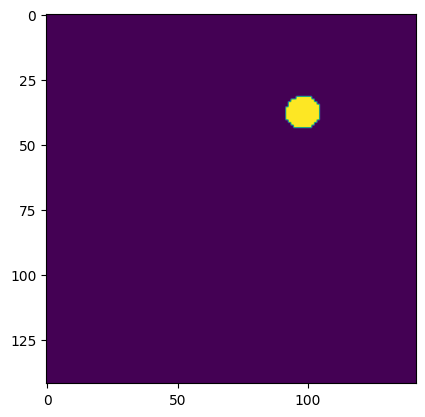

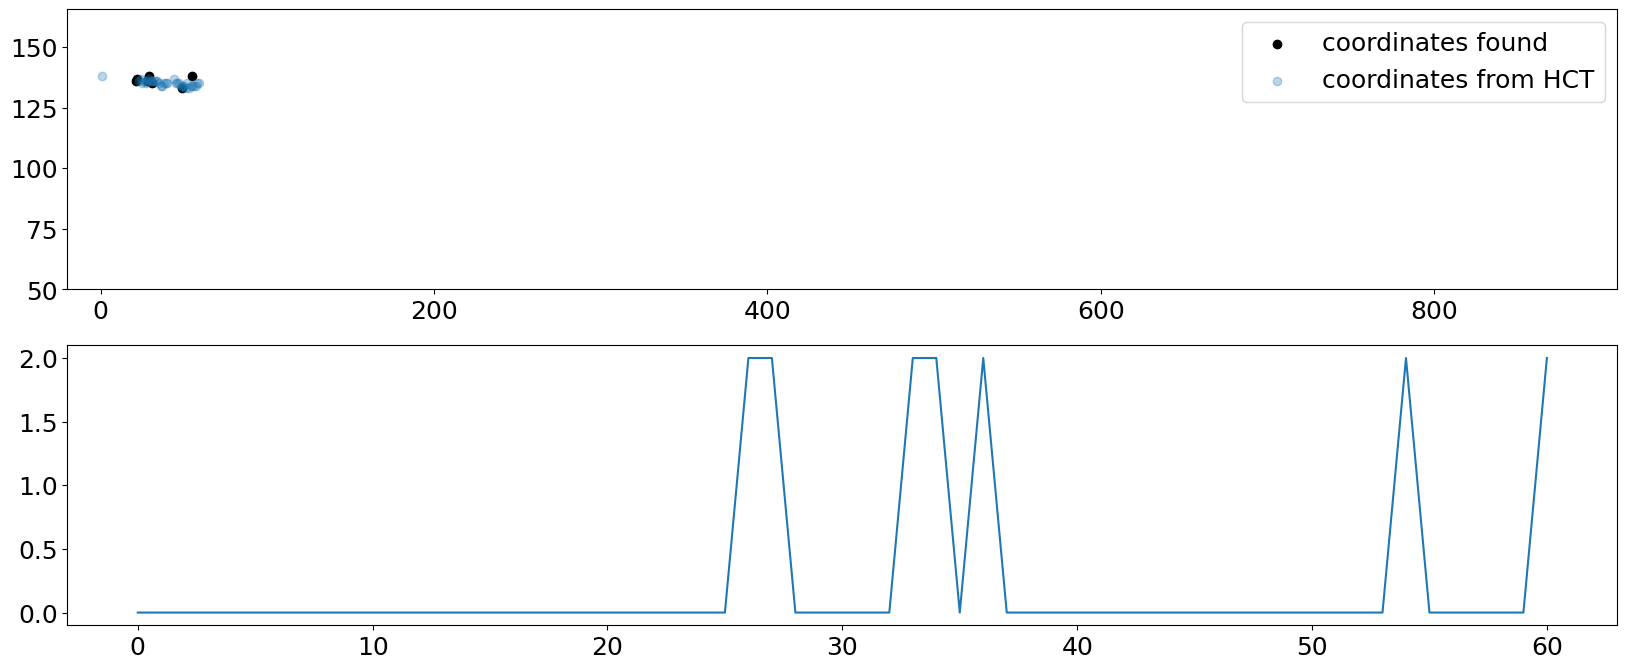

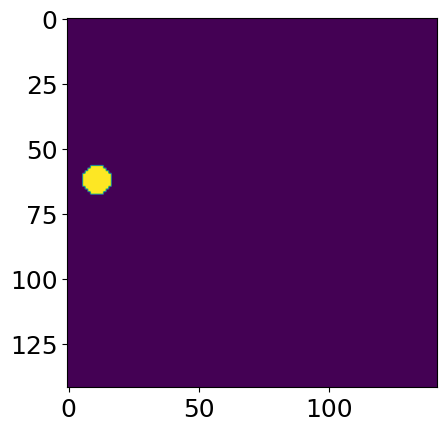

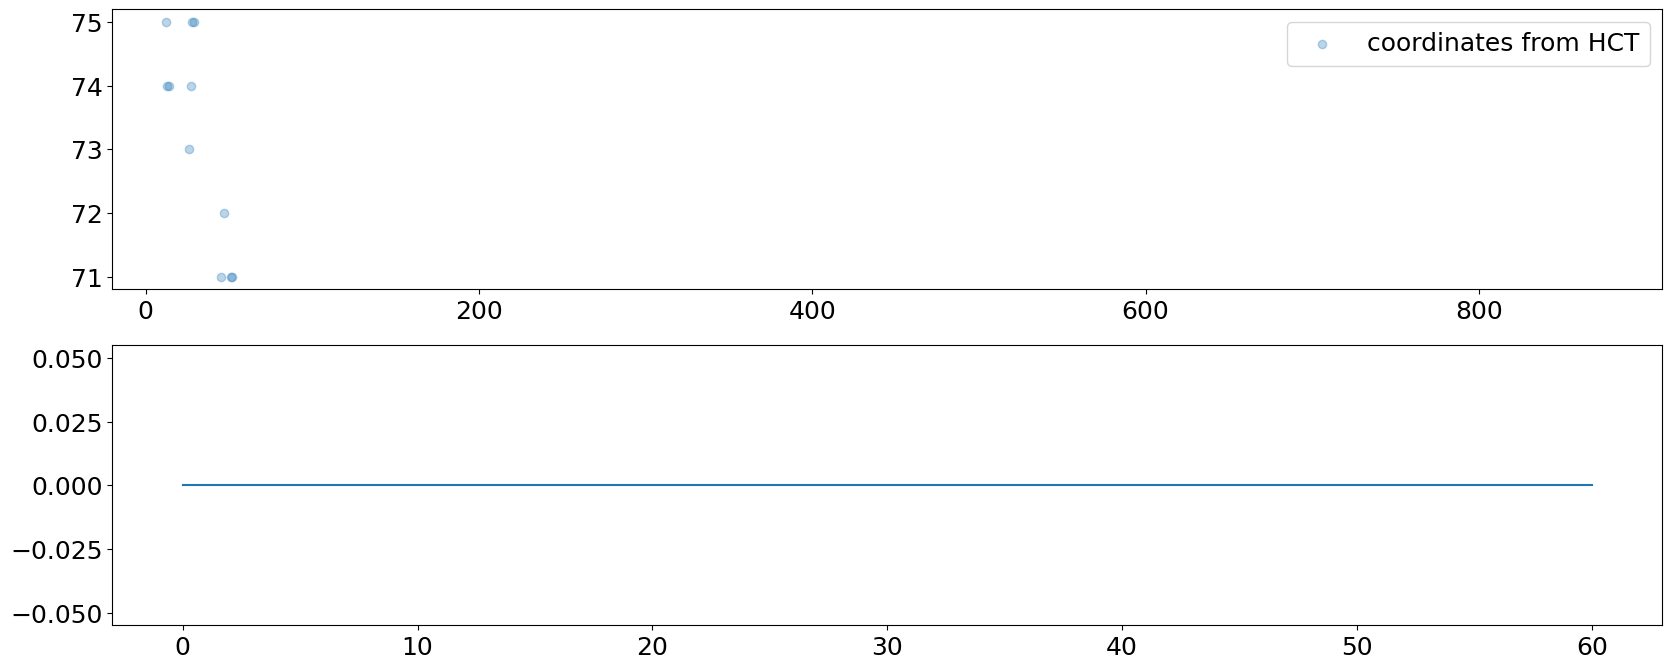

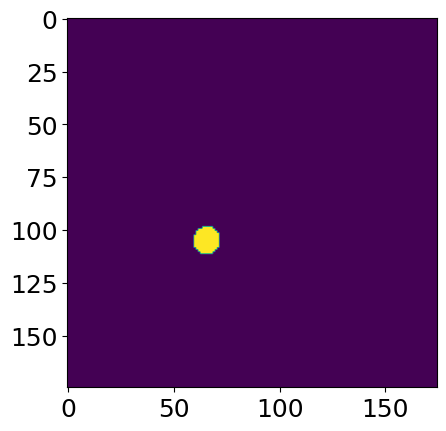

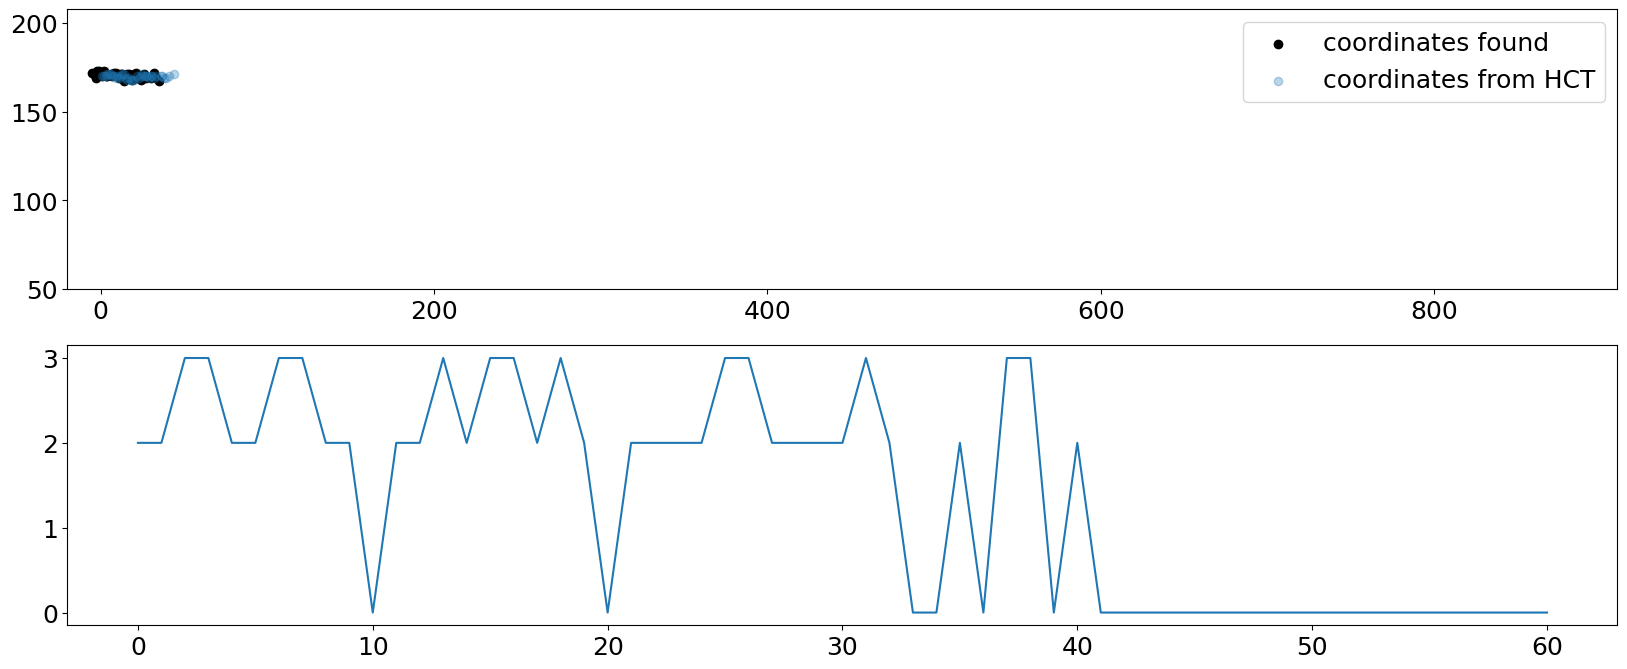

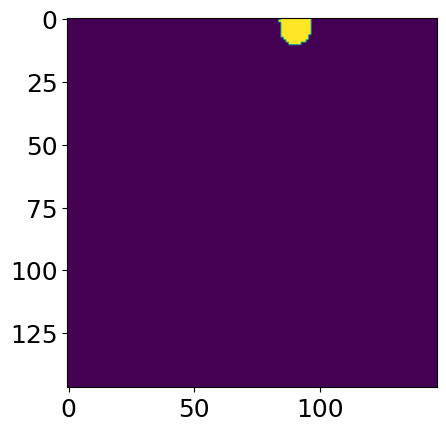

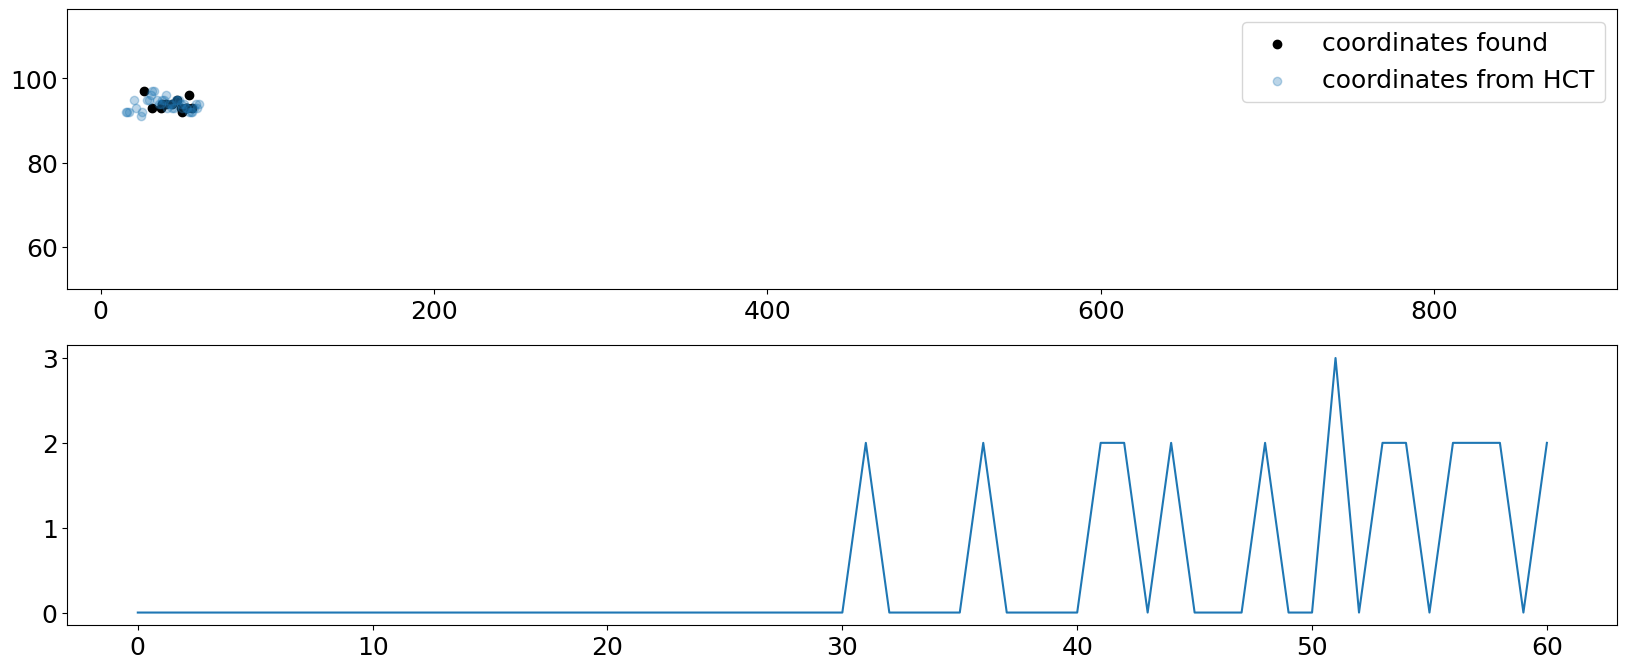

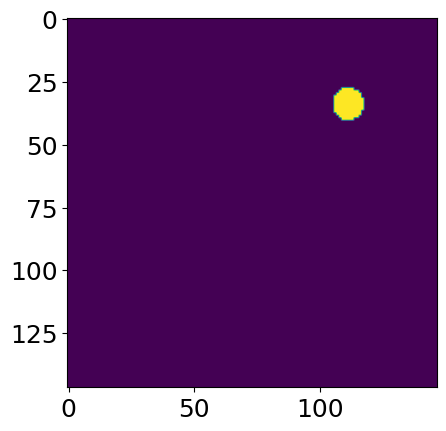

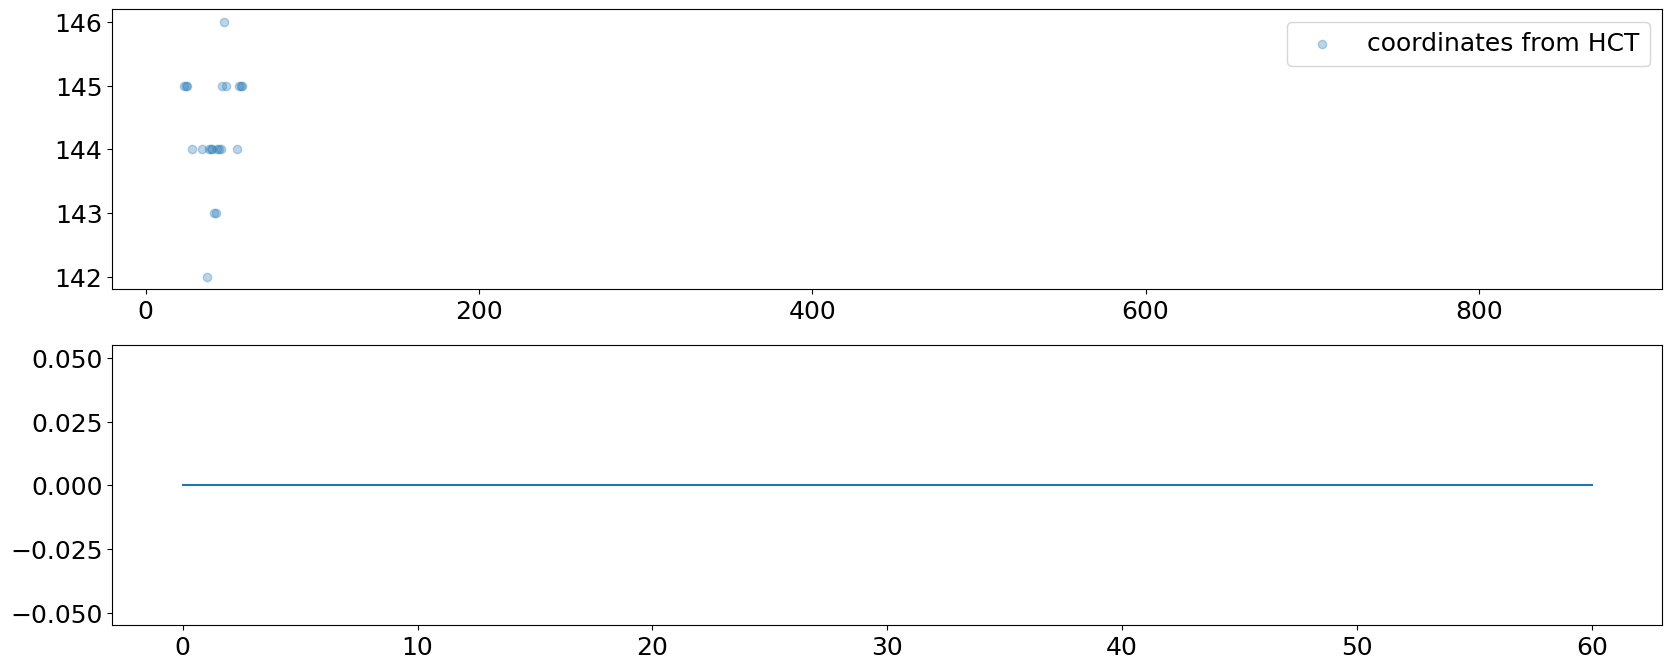

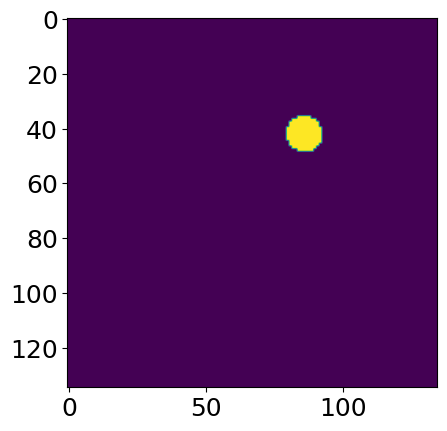

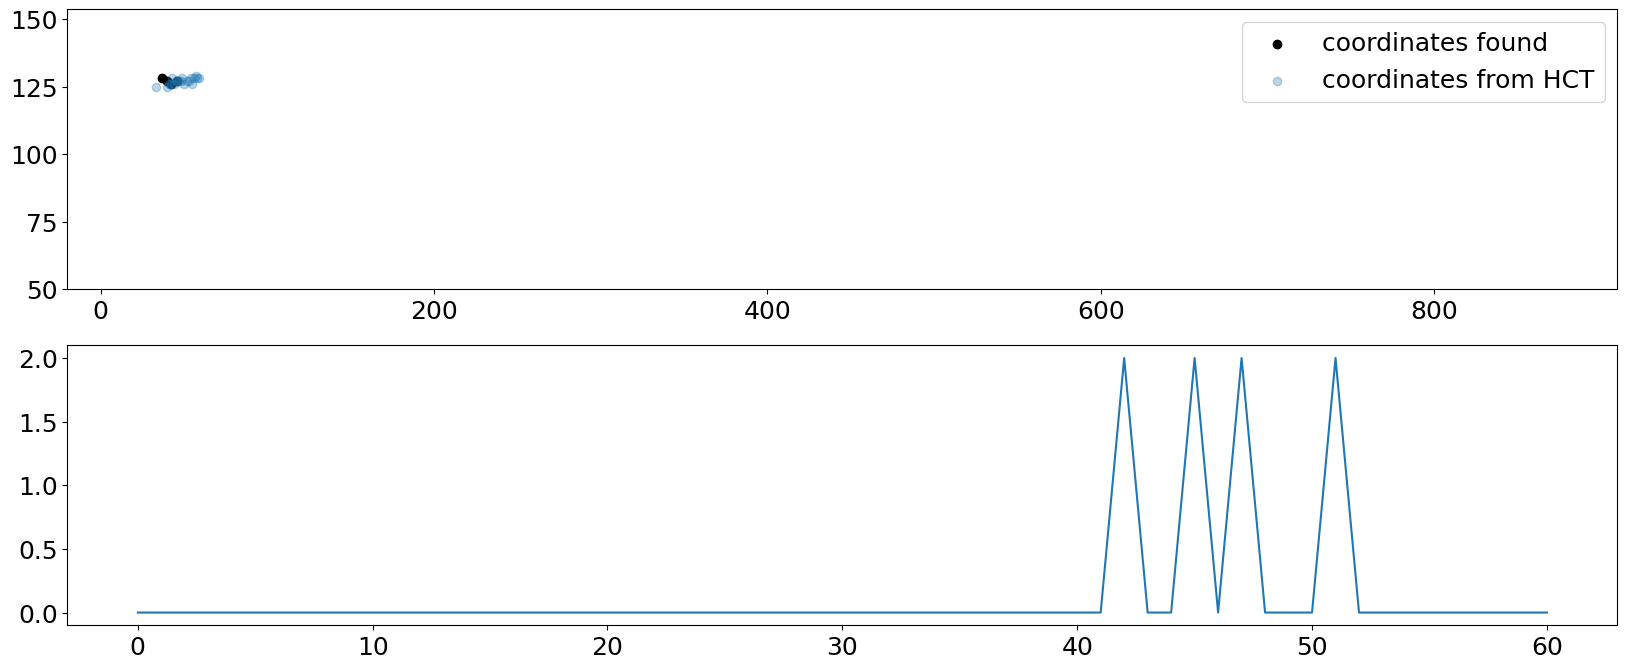

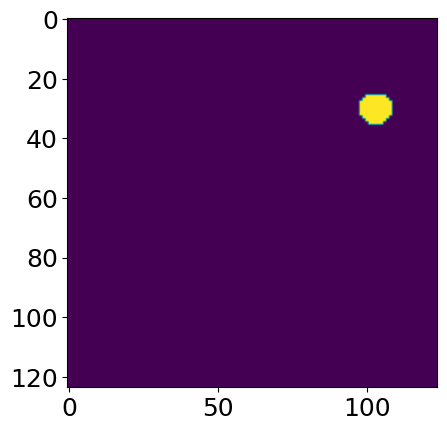

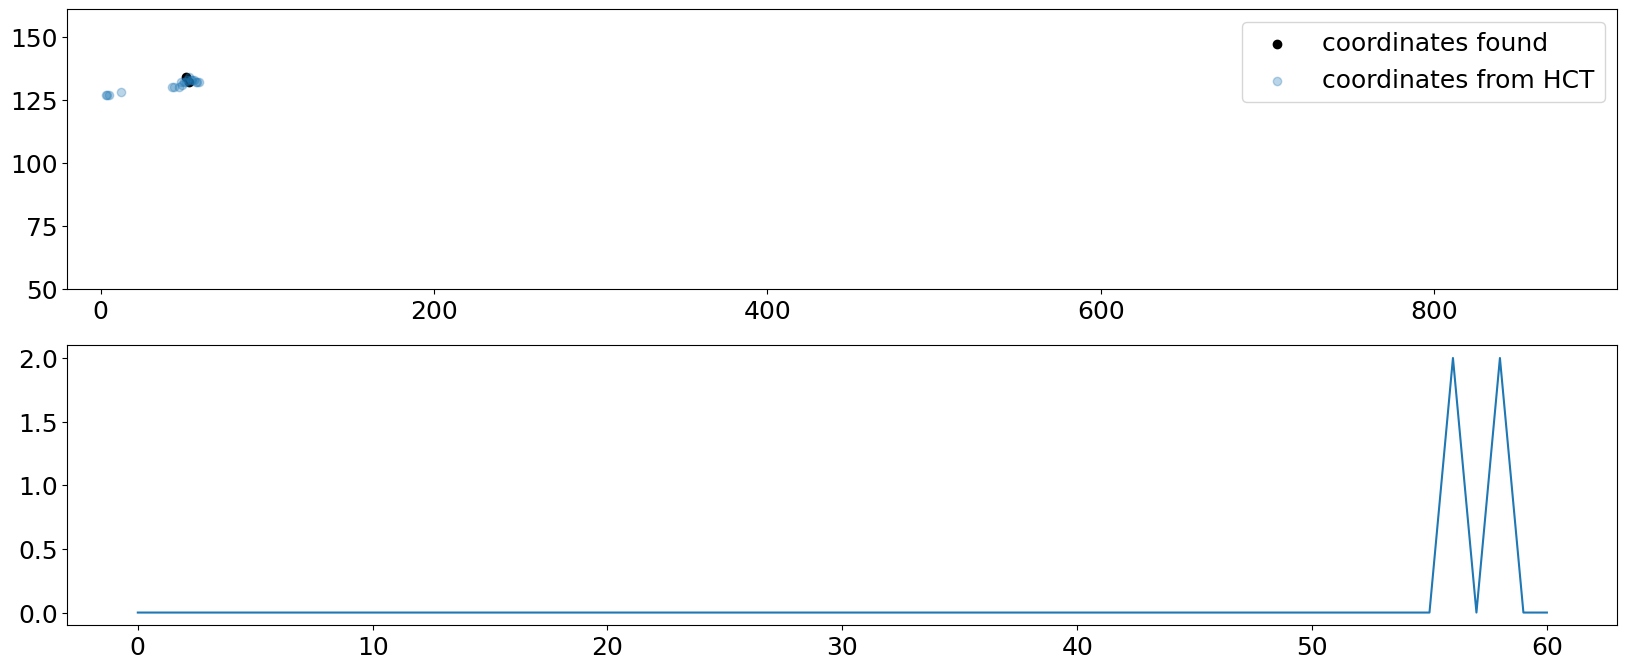

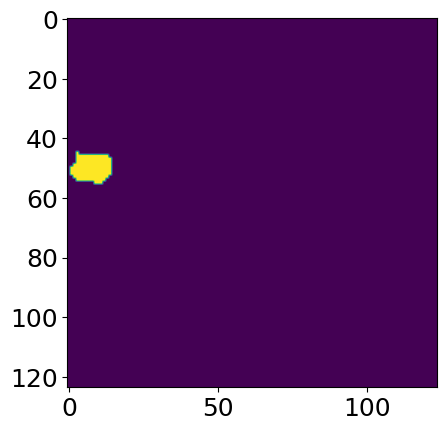

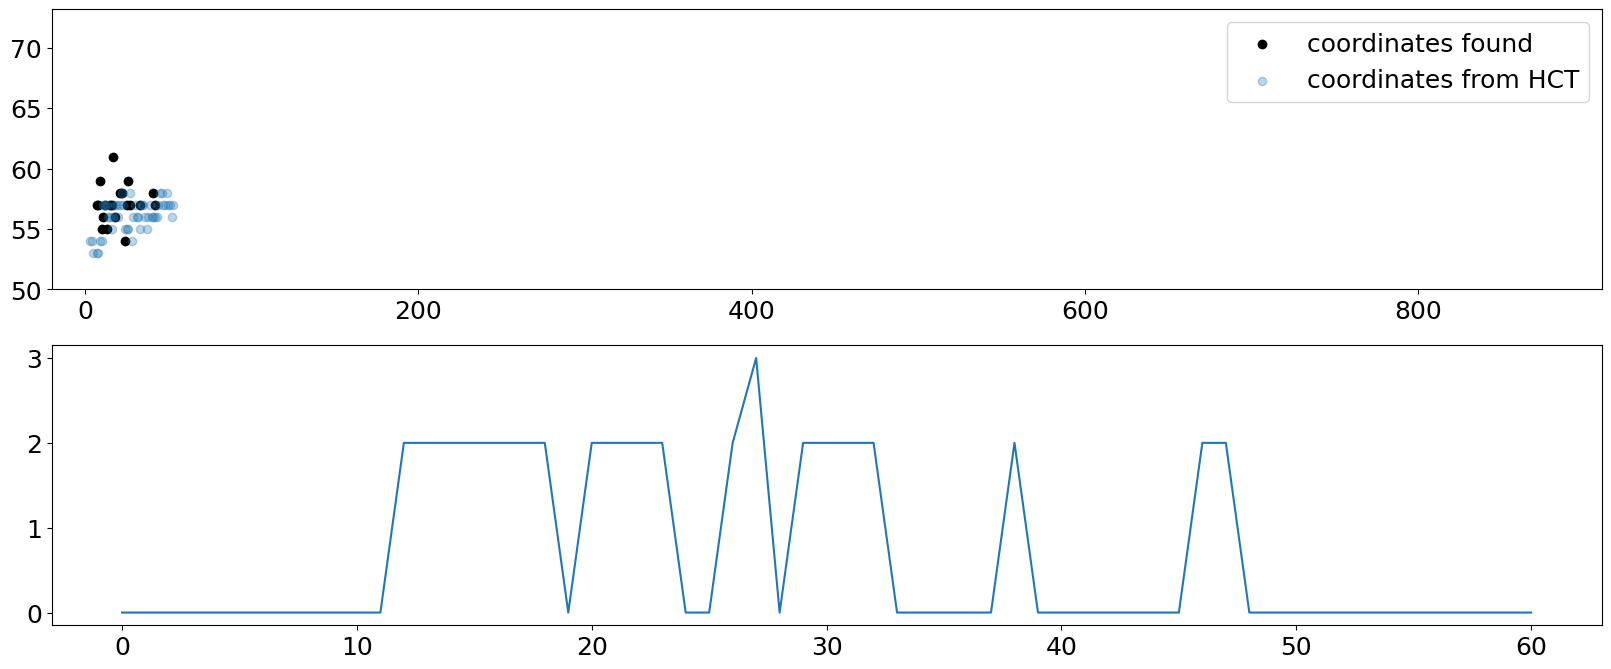

In [12]:
for cellNumber in cellsList:
    # cellNumber = chosenCell
    print('cellNumber, ', cellNumber)
    potentialTxsFinal=[]
    trackFilePath = os.path.join(baseFolder,cellNumber)
    trackFilesToAnalyse = [os.path.join(trackFilePath,i) for i in os.listdir(trackFilePath) if 'mrnaTracks' in i]
    print(trackFilesToAnalyse)
    if len(trackFilesToAnalyse)!=0:

        ## Load Tracks for cell

        for trackTobeAnalysed in range(len(trackFilesToAnalyse)):
            trackPath = Path(trackFilesToAnalyse[trackTobeAnalysed])

            trackFile = trackPath.name
            cellFolderPath = trackPath.parents[0]
            total_number_of_tx_site = len(trackFilesToAnalyse)

            thresholdFile = pd.read_csv(cellFolderPath.parent.joinpath('thresholds.csv'), index_col=0)
            extension = '.tif'
            print('cellNumber = ', cellNumber)
            idx = np.where(thresholdFile['cell'] == cellNumber)[0][0]

            thresholdSelected = thresholdFile['threshold'][idx]
            sequenceCell = imr(str(cellFolderPath.joinpath('*.tif')))
            mipSequenceCell = np.max(sequenceCell, axis=1)
            MaxTimePoint = sequenceCell.shape[0]
            spcl = np.load(cellFolderPath.joinpath(str(cellNumber)+'_spots_and_clusters_27_May'+al+'.npz'),allow_pickle=True)
            reference_spot = spcl['reference_spot']

            ## Get mrna number for Transcription site tracks

            particle = pd.read_pickle(trackPath)
            particle.index = np.arange(0,len(particle))
            particle.track_length = len(particle)

            newClusterFrame = []
            tracksParticles = []

            spotsFrame = spcl['spotsFrame']
            clustersFrames = spcl['clustersFrames']
            refSpot = deepcopy(reference_spot)

            cell_label_clean_file = cellFolderPath.parent.joinpath('masks_tx/blur_'+cellNumber+'.npy')
            tx_label_file = np.load(cell_label_clean_file)
            Tx_mask_new = np.array(label(tx_label_file),dtype=bool)

            cell_label_clean = tx_label_file
            region=int(trackFile.split('.')[0].split('Tracks_')[-1])
            print('Displaying region ', region)
            Tx_mask_new = cell_label_clean==region
            plt.figure()
            plt.imshow(Tx_mask_new)

            clsFrm = cleanClusters(clustersFrames,Tx_mask_new)

            #------------------------ Set probability

            probTx = setProbability(particle)

            #----------------------- Find Detected Txs
            potentialTxs = findDetectedTxs(clsFrm, particle, MaxTimePoint, probTx)

            #------------------- Plot Txs position
            plotFileName = os.path.join(pathToResults,cellNumber+'_coordinates_and_plot_region_'+str(region)+'.png')
            plotCoordinatesFound(potentialTxs, particle, plotFileName)


            #--------------------- Find Clusters -----------------
            selectedThreshold = float(thresholdFile['threshold'][thresholdFile['cell']==str(cellNumber)].iloc[0])
            potentialTxs = findMissingTranscriptionSitesFromTracks(potentialTxs, 
                                                    probTx,
                                                    particle,
                                                    spotsFrame,
                                                    voxelRadius, 
                                                    objectRadius,
                                                    selectedThreshold, 
                                                    sequenceCell, 
                                                    reference_spot,
                                                    cellNumber, 
                                                    Tx_mask_new, 
                                                    BETA=1, 
                                                    gM=3,
                                                    nP=1)

            potentialTxs, potentialTxsFinal = modifyFinalTrackDataFrame(potentialTxs, potentialTxsFinal, total_number_of_tx_site)
        print(pathToResults)
        columnHd, newClusterFrame, tableToDisplay, dftracksFinal = makeTrackData(potentialTxsFinal)
        saveTableAndCoordinates(potentialTxsFinal)
        print('cell ', cellNumber)
        potentialTxsFinal.to_pickle(os.path.join(pathToResults,cellNumber+'_finalDataframe.pkl'))
        np.savez(os.path.join(pathToResults,cellNumber+'newClusters.npz'),newClusterFrame=newClusterFrame)